In [1]:
import base64
import datetime
import json
import os
import random
import time

import scipy
from scipy import ndimage
import numpy as np
import pandas as pd
import sklearn
import matplotlib as mpl
import matplotlib.pyplot as plt
from pylab import rcParams
import seaborn as sns
import statsmodels as sm
from pylab import rcParams
from pylab import *
from matplotlib.dates import date2num , DateFormatter
from PIL import Image

np.random.seed(1337)

%matplotlib inline
sns.set(font_scale=1.0)
rcParams['figure.figsize'] = 8, 6
sns.set_style('whitegrid')
sns.set_palette(sns.color_palette('muted'))

pd.options.display.max_rows = 999
pd.options.display.max_columns = 999
pd.options.display.max_colwidth = 1000

/usr/local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


# Load the Data

In [2]:
raw_data = pd.read_json('tmp/raw_data.json', convert_dates=['created'])

raw_data.index.name = 'id'
d = raw_data[['created']]
print len(d)

124011


In [ ]:
# d.loc[:, 'created_utc'] = d.created.map(lambda x: x.tz_localize('utc'))
# d.loc[:, 'created_local_time']  = d.created_utc.map(lambda x: x.tz_convert('US/Eastern'))
# d[['created', 'created_local_time']].head()

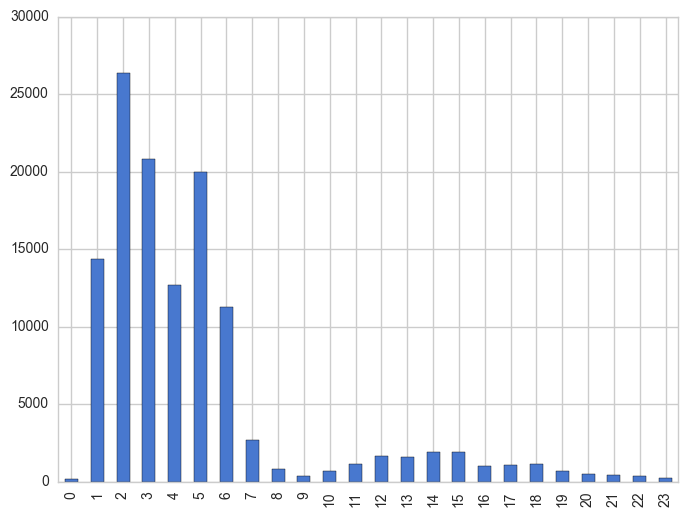

In [3]:
d.created.map(lambda x: x.hour).value_counts().sort_index().plot(kind='bar')

In [4]:
#d.created_local_time.map(lambda x: x.hour).value_counts().sort_index().plot(kind='bar')

In [5]:
d.dtypes

created    datetime64[ns]
dtype: object

In [6]:
d.head()

,created
id,
0,2016-06-11 05:29:41
1,2016-06-24 06:36:34
10,2016-06-24 07:54:24
100,2016-06-03 04:29:40
1000,2016-06-11 06:17:35


### Split date of creation into more atomic, numeric features
   * created_month
   * created_day_of_month
   * created_dow
   * created_hour
   * created_minute
   * created_minute_of_the_day

In [7]:
d.loc[:, 'created_month'] = d['created'].map(lambda x: x.month)

d.loc[:, 'created_day_of_month'] = d['created'].map(lambda x: x.day)

d.loc[:, 'created_dow'] = d['created'].map(lambda x: x.dayofweek)

d.loc[:, 'created_hour'] = d['created'].map(lambda x: x.hour).astype(float64)

d.loc[:, 'created_minute'] = d['created'].map(lambda x: x.minute).astype(float64)

d.loc[:, 'created_minute_of_the_day'] = d['created'].map(lambda x: 60 * x.hour + x.minute ).astype(float64)

#d.loc[:, 'created_date'] = d.created_local_time.map(lambda x: x.date())

exp_start = datetime.datetime(2016, 4, 1)
d.loc[:, 'created_hour_of_dataset'] = d.created.apply(lambda x: (
        (x - exp_start).days * 24 + ((x - exp_start).seconds / 3600))).astype(float64)
d.head()

/Library/Python/2.7/site-packages/pandas/core/indexing.py:288: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Library/Python/2.7/site-packages/pandas/core/indexing.py:465: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


,created,created_month,created_day_of_month,created_dow,created_hour,created_minute,created_minute_of_the_day,created_hour_of_dataset
id,,,,,,,,
0,2016-06-11 05:29:41,6,11,5,5.0,29.0,329.0,1709.0
1,2016-06-24 06:36:34,6,24,4,6.0,36.0,396.0,2022.0
10,2016-06-24 07:54:24,6,24,4,7.0,54.0,474.0,2023.0
100,2016-06-03 04:29:40,6,3,4,4.0,29.0,269.0,1516.0
1000,2016-06-11 06:17:35,6,11,5,6.0,17.0,377.0,1710.0


### Distance from daily peak

Find what is the global peak in a day for created values and compute time diff in minutes (or hours)
Let's find the busiest hour of the day and let's consider the middle of this hour the "peak minute".
And the distance from the peak will be:
"peak minute" - "minute of creation"


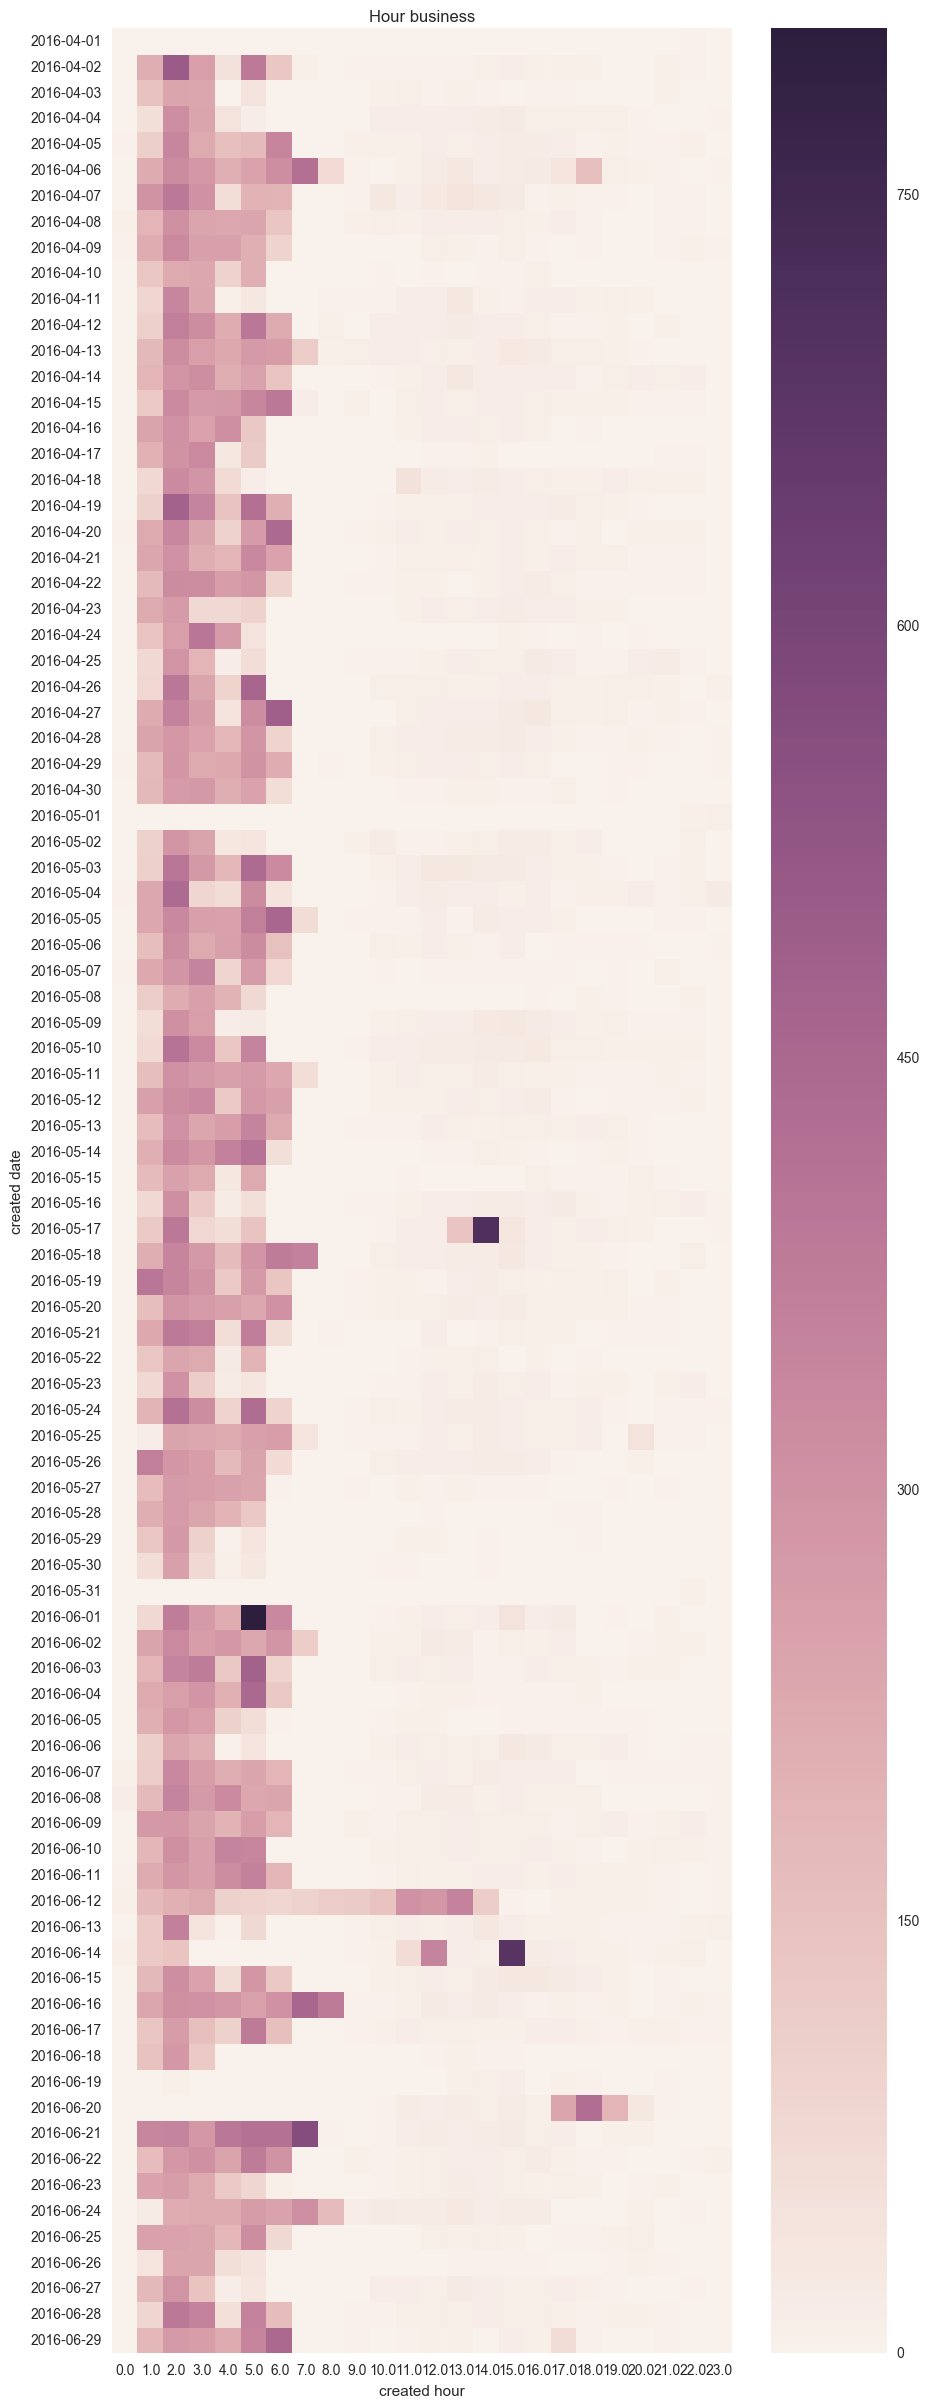

In [9]:
created_date = d.created.map(lambda x: x.date())
busy_hours_per_day = pd.crosstab(created_date, d['created_hour'])

plt.figure(figsize=(10, 30))
ax = sns.heatmap(
        data=busy_hours_per_day)
_ = ax.set_xlabel('created hour')
_ = ax.set_ylabel('created date')
_ = ax.set_title('Hour business')

In [10]:
peak_hours = busy_hours_per_day.idxmax(axis=1).to_dict()
def distance_from_peak(created):
    min_of_day =  60 * created.hour + created.minute
    peak_hour = peak_hours[pd.to_datetime(created).date()]
    peak_hour_central_minute = 60 * peak_hour + 30
    return peak_hour_central_minute - min_of_day
    
d.loc[:, 'created_distance_from_peak'] = d.created.map(distance_from_peak).astype(float64)
d.head()

,created,created_month,created_day_of_month,created_dow,created_hour,created_minute,created_minute_of_the_day,created_hour_of_dataset,created_distance_from_peak
id,,,,,,,,,
0,2016-06-11 05:29:41,6,11,5,5.0,29.0,329.0,1709.0,1.0
1,2016-06-24 06:36:34,6,24,4,6.0,36.0,396.0,2022.0,54.0
10,2016-06-24 07:54:24,6,24,4,7.0,54.0,474.0,2023.0,-24.0
100,2016-06-03 04:29:40,6,3,4,4.0,29.0,269.0,1516.0,61.0
1000,2016-06-11 06:17:35,6,11,5,6.0,17.0,377.0,1710.0,-47.0


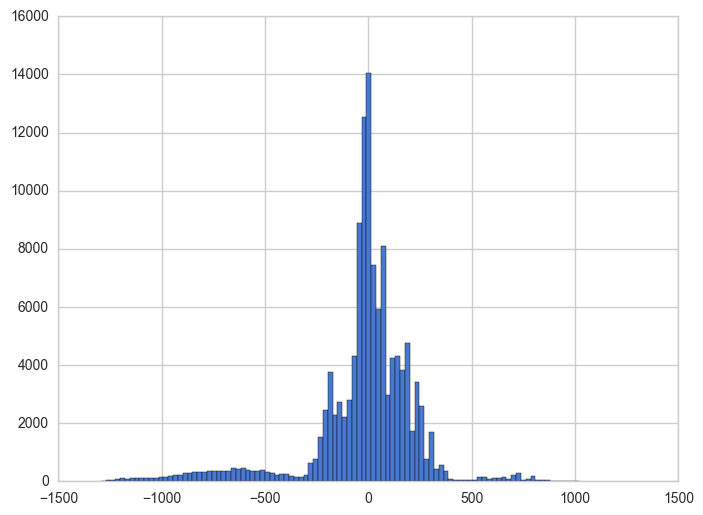

In [11]:
d.created_distance_from_peak.hist(bins=100)

In [ ]:
#Aggregated features
# num_apts_same_day
#d.loc[:, 'num_apts_same_day'] = d.groupby(['created_date'])['created_hour'].transform(lambda x: x.count())

# num_apts_same_hour
#d.loc[:, 'num_apts_same_hour'] = d.groupby(['created_date', 'created_hour'])['created_hour'].transform(lambda x: x.count())

# number of other listings created in the time window +/- 30 minutes of creation
# number of other listings created in the previous 60 minutes
# number of other listings created in the next 60 minutes
# number of other listings created in the time window +/- 12 hours of creation
# number of other listings created in the previous 24 hours
# number of other listings created in the next 24 hours
#d.head()

In [12]:
#Datastructure:

creation_cdf_in_time = d.created.map(lambda t: t.strftime('%Y-%m-%d %H:%M')).sort_values().value_counts().sort_index().cumsum()
creation_cdf_in_time_dict = creation_cdf_in_time.to_dict()


In [13]:
from pandas.tseries.offsets import Minute
first = pd.Timestamp(min(creation_cdf_in_time_dict.keys()))
last = pd.Timestamp(max(creation_cdf_in_time_dict.keys()))

all_minutes = 24*60*(last - first).components.days + 60*(last - first).components.hours + (last - first).components.minutes

listings_seen = 0
for min_offset in range(0, all_minutes + 1):
    ts = (first + Minute(min_offset)).strftime('%Y-%m-%d %H:%M')
    if ts not in creation_cdf_in_time_dict:
        creation_cdf_in_time_dict[ts] = listings_seen
    else:
        listings_seen = creation_cdf_in_time_dict[ts]
total = creation_cdf_in_time.max()

In [15]:
#http://stackoverflow.com/questions/12141150/from-list-of-integers-get-number-closest-to-a-given-value

def get_listings_in_timeframe(created, mins_before, mins_after):
    interval_start = (created - Minute(mins_before)).strftime('%Y-%m-%d %H:%M')
    interval_end = (created + Minute(mins_after)).strftime('%Y-%m-%d %H:%M')
    return creation_cdf_in_time_dict.get(interval_end, total) - creation_cdf_in_time_dict.get(interval_start, 0)

d.loc[:, 'num_apts_same_3hours'] = d.created.map(lambda x: get_listings_in_timeframe(x, 90, 90)).astype(float64)
d.loc[:, 'num_apts_prev_3hours'] = d.created.map(lambda x: get_listings_in_timeframe(x, 180, 0)).astype(float64)
d.loc[:, 'num_apts_next_3hours'] = d.created.map(lambda x: get_listings_in_timeframe(x, 0, 180)).astype(float64)

d.loc[:, 'num_apts_same_2days'] = d.created.map(lambda x: get_listings_in_timeframe(x, 60*24, 60*24)).astype(float64)
d.loc[:, 'num_apts_prev_2days'] = d.created.map(lambda x: get_listings_in_timeframe(x, 60*48, 0)).astype(float64)
d.loc[:, 'num_apts_next_2days'] = d.created.map(lambda x: get_listings_in_timeframe(x, 0, 60*48)).astype(float64)

d.head()

,created,created_month,created_day_of_month,created_dow,created_hour,created_minute,created_minute_of_the_day,created_hour_of_dataset,created_distance_from_peak,num_apts_same_3hours,num_apts_prev_3hours,num_apts_next_3hours,num_apts_same_2days,num_apts_prev_2days,num_apts_next_2days
id,,,,,,,,,,,,,,,
0,2016-06-11 05:29:41,6,11,5,5.0,29.0,329.0,1709.0,1.0,866.0,883.0,370.0,2826.0,3320.0,3582.0
1,2016-06-24 06:36:34,6,24,4,6.0,36.0,396.0,2022.0,54.0,793.0,732.0,591.0,3307.0,2396.0,2781.0
10,2016-06-24 07:54:24,6,24,4,7.0,54.0,474.0,2023.0,-24.0,641.0,824.0,245.0,3303.0,2682.0,2414.0
100,2016-06-03 04:29:40,6,3,4,4.0,29.0,269.0,1516.0,61.0,981.0,909.0,618.0,3599.0,4278.0,3196.0
1000,2016-06-11 06:17:35,6,11,5,6.0,17.0,377.0,1710.0,-47.0,644.0,940.0,101.0,2709.0,3346.0,3312.0


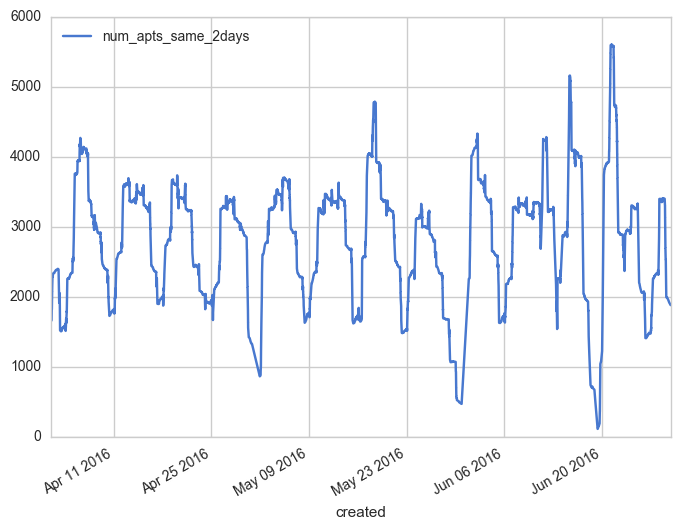

In [18]:
d.plot(x='created', y='num_apts_same_2days')

# Save the Data

In [19]:
del d['created']

In [20]:
d.to_csv('tmp/features_created.csv')